In [1]:
import torch
torch.__version__
torch.cuda.is_available()

True

In [2]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader

import psycopg2
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0, c0):
        h0 = torch.zeros(num_layers,  hidden_size).to(device)
        c0 = torch.zeros(num_layers,  hidden_size).to(device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out, (hn, cn)

def expand_data(dataframe):
    '''inputs: original dataframe with values for ONE station'''

    dataframe_copy = dataframe.copy()

    # create new dataframe with index as every hour
    dataframe_copy['Time'] = pd.to_datetime(dataframe_copy['charging_hour'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)

    start_index = dataframe_copy.iloc[0, -1].date() #starting point is the day of the first index
    end_index = dataframe_copy.iloc[-1, -1].date() # ending pojnt is the day of the last index
    indices = pd.date_range(start_index, end_index, freq='1H')

    dataframe_copy.set_index('Time', inplace=True)

    print(dataframe.describe())
    #dataframe.describe().to_csv('Opis podataka Osijek.csv', sep=';')

    # new_dataframe is a dataframe that is expanded with zero values
    new_dataframe = pd.DataFrame(index=indices, data=dataframe_copy)

    # important features (charging_minutes, consumption, utilization) are filled with zeros
    # other values (that are the same for each time step) are copied - like connector_count and location_accesstype
    #new_dataframe['location_accesstype_title'] = new_dataframe['location_accesstype_title'].fillna(dataframe_copy['location_accesstype_title'][0])
    new_dataframe['charging_hour'] = new_dataframe['charging_hour'].fillna(np.nan)
    # charging_hour column is filled with Nan values because it will be later dropped and is not necessary
    new_dataframe['utilization'] = new_dataframe['utilization'].fillna(0.0)
    #new_dataframe['connector_count'] = new_dataframe['connector_count'].fillna(dataframe_copy['connector_count'][0])
    #new_dataframe['congested_connectors'] = new_dataframe['congested_connectors'].fillna(0.0)
    #new_dataframe['energy_consumption'] = new_dataframe['energy_consumption'].fillna(0.0)
    #new_dataframe['charging_minutes'] = new_dataframe['charging_minutes'].fillna(0.0)

    # new_dataframe is then save to the .csv file
    # new_dataframe.to_csv(r'C:\Users\ZVNE\OneDrive - fer.hr\projekti\E-Mobility Grčka\station data expanded ' + str(name) + '.csv', sep=';')

    # expanded dataframe is returned
    return new_dataframe

from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    #df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'util(t-{i})'] = df['utilization'].shift(i)

    #df.dropna(inplace=True)

    return df



# Read the data from CSV
data = pd.read_csv("station_data_hour_Opatija.csv")


# Provide the dataframe from database
data_station = data.copy()

# Get the user-provided value to filter on

data_station = data_station[["utilization","charging_hour"]]
data_station


expanded_data_op = expand_data(data_station)
expanded_data_op

filter_data = expanded_data_op.copy() # here we selected which of the three stations is used


lookback = 128
shifted_df = prepare_dataframe_for_lstm(filter_data, lookback)
shifted_df

for i in range(1, lookback+1):
  shifted_df[f'util(t-{i})'] = shifted_df[f'util(t-{i})'].fillna(0.0)

shifted_df = shifted_df.drop(columns = "charging_hour", axis = 1)

shifted_df_as_np = shifted_df.to_numpy()

X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X = dc(np.flip(X, axis=1))
X[0]

train_size = int(len(filter_data) * 0.8)
val_size = int(len(filter_data) * 0.1)
test_size = len(filter_data) - train_size - val_size

X_train = X[:train_size]
X_val = X[train_size:train_size+val_size]
X_test = X[train_size+ val_size:]

y_train = y[:train_size]
y_val = y[train_size:train_size+val_size]
y_test = y[train_size+ val_size:]

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

X_train = X_train.reshape((-1, lookback))
X_val = X_val.reshape((-1, lookback))
X_test = X_test.reshape((-1, lookback))

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_dataset.X.size(1)  # Number of features in the input data
hidden_size = 250  # Number of units in the LSTM hidden layer
num_layers = 4  # Number of LSTM layers
output_size = 1  # Number of output features (energy consumption and utilization)
learning_rate = 0.0005
num_epochs = 150
batch_size = 128

# Create data loaders

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize hidden states and cell states on the specified device
h0 = torch.zeros(num_layers,  hidden_size).to(device)
c0 = torch.zeros(num_layers,  hidden_size).to(device)

# Placeholder for the best validation accuracy
best_val_loss = float('inf')  # Initialize with a large value
best_model_state = None

# Training loop
for epoch in range(num_epochs):
    h0 = torch.zeros(num_layers,  hidden_size).to(device)
    c0 = torch.zeros(num_layers,  hidden_size).to(device)
    model.train()
    total_loss = 0
    for batch_idx, (features, labels) in enumerate(train_loader):

        features, labels = features.to(device), labels.to(device)  # Move data to the specified device
        h0 = h0.to(device)
        c0 = c0.to(device)
        # Forward pass with hidden states
        #print(features.shape)
        outputs, (h0, c0) = model(features, h0.detach(), c0.detach())
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    predictions = []
    with torch.no_grad():
        # Initialize validation hidden states and cell states with the final states of the training set
        h0_val = h0.detach().clone()
        c0_val = c0.detach().clone()

        for batch_idx, (features, labels) in enumerate(val_loader):
            features, labels = features.to(device), labels.to(device)

            # Forward pass with hidden states
            outputs, (h0_val, c0_val) = model(features, h0_val, c0_val)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # store predictions
            predictions.extend(outputs.cpu().numpy())

    average_val_loss = val_loss / len(val_loader)
    # keep the model with the best performance in the validation set
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_model_state = model.state_dict()
        best_predictions = predictions

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}')

print('Training finished.')
print(best_val_loss)

model.load_state_dict(best_model_state)

# Save the best predictions for plotting (optional, you can save them for future use)
np.save('best_predictions.npy', np.array(best_predictions))


with torch.no_grad():
    predicted, (h0_val,c0_val) = model(X_test.to(device),h0_val, c0_val)
    #print((h0_val,c0_val))


new_in = predicted[-129:-1]
new_in = torch.unsqueeze(torch.squeeze(new_in, 1),0)
predicted, (h0_val,c0_val) = model(new_in,h0_val, c0_val)
new_in = torch.cat((new_in,predicted),1)
new_in = new_in[0][1:]
new_in = torch.unsqueeze(new_in,0)

predictions = []
for i in range(200):
  predicted, (h0_val,c0_val) = model(new_in,h0_val, c0_val)
  new_in = torch.cat((new_in,predicted),1)
  new_in = new_in[0][1:]
  new_in = torch.unsqueeze(new_in,0)
  predictions.append(predicted.item())


plt.plot(np.array(predictions), label='Predicted Utilization')
plt.xlabel('hour')
plt.ylabel('Utilization')
plt.legend()
plt.show()

'''
print(predicted.shape)
plt.plot(np.array(y_test), label='Actual Close')
plt.plot((predicted.cpu()), label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


# Plot the best predictions for "energy consumption" and "utilization" separately
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot "energy consumption" predictions
ax1.plot(np.array(best_predictions)[:, 0], label='Utilization (Predicted)', color='orange')
ax1.plot(val_dataset.y.numpy()[:, 0], label='Utilization (True)', color='blue')
ax1.set_ylabel('Utilization')
ax1.legend()


plt.xlabel('Time Step')
plt.show()

'''


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

def expand_data(dataframe, name):
    '''inputs: original dataframe with values for ONE station'''

    dataframe_copy = dataframe.copy()

    # create new dataframe with index as every hour
    dataframe_copy['Time'] = pd.to_datetime(dataframe_copy['charging_hour'], format='%Y-%m-%d %H:%M:%S+00:00').dt.tz_localize(None)

    start_index = dataframe_copy.iloc[0, -1].date() #starting point is the day of the first index
    end_index = dataframe_copy.iloc[-1, -1].date() # ending pojnt is the day of the last index
    indices = pd.date_range(start_index, end_index, freq='1H')

    dataframe_copy.set_index('Time', inplace=True)

    print(dataframe.describe())
    #dataframe.describe().to_csv('Opis podataka Osijek.csv', sep=';')

    # new_dataframe is a dataframe that is expanded with zero values
    new_dataframe = pd.DataFrame(index=indices, data=dataframe_copy)

    # important features (charging_minutes, consumption, utilization) are filled with zeros
    # other values (that are the same for each time step) are copied - like connector_count and location_accesstype
    new_dataframe['location_accesstype_title'] = new_dataframe['location_accesstype_title'].fillna(dataframe_copy['location_accesstype_title'][0])
    new_dataframe['charging_hour'] = new_dataframe['charging_hour'].fillna(np.nan)
    # charging_hour column is filled with Nan values because it will be later dropped and is not necessary
    new_dataframe['utilization'] = new_dataframe['utilization'].fillna(0.0)
    new_dataframe['connector_count'] = new_dataframe['connector_count'].fillna(dataframe_copy['connector_count'][0])
    new_dataframe['congested_connectors'] = new_dataframe['congested_connectors'].fillna(0.0)
    new_dataframe['energy_consumption'] = new_dataframe['energy_consumption'].fillna(0.0)
    new_dataframe['charging_minutes'] = new_dataframe['charging_minutes'].fillna(0.0)

    # new_dataframe is then save to the .csv file
    # new_dataframe.to_csv(r'C:\Users\ZVNE\OneDrive - fer.hr\projekti\E-Mobility Grčka\station data expanded ' + str(name) + '.csv', sep=';')

    # expanded dataframe is returned
    return new_dataframe

class CustomDataset(Dataset):
    def __init__(self, seq_len=5, max_len=1000, seq = []):
        super(CustomDataset).__init__()
        self.datalist = seq
        self.data, self.targets = self.timeseries(self.datalist, seq_len)

    def __len__(self):
        return len(self.data)

    def timeseries(self, data, window):
        temp = []
        targ = data[window:]
        for i in range(len(data)-window):
            temp.append(data[i:i+window])

        return np.array(temp), targ

    def __getitem__(self, index):
        x = torch.tensor(self.data[index]).type(torch.Tensor)
        y = torch.tensor(self.targets[index]).type(torch.Tensor)
        return x,y


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # hidden states not defnined hence the value of h0,c0 == (0,0)
        out, (hn, cn) = self.lstm(x)

        # as the diagram suggest to take the last output in many to one
        # print(out.shape)
        # print(hn.shape)
        # all batch, last column of seq, all hidden values
        out = out[:, -1, :]
        out = self.fc(out)

        return out


df = pd.read_csv('station_data_hour_Opatija.csv')



expanded_data = expand_data(df, "name1")
print(expanded_data)
data = expanded_data['utilization']
print(data)
data_np = data.to_numpy()

train_size = int(len(data_np) * 0.8)
val_size = int(len(data_np) * 0.1)
test_size = len(data_np) - train_size - val_size

train = data_np[:train_size]
val = data_np[train_size:train_size+val_size]
test = data_np[train_size+ val_size:]

train_dataset = CustomDataset(seq_len=64, max_len=len(train), seq = train)
val_dataset = CustomDataset(seq_len=64, max_len=len(val), seq = val)
test_dataset = CustomDataset(seq_len=64, max_len=len(test), seq = test)


train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
#collate_fn=custom_collector

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNN(input_size=1, hidden_size=256, num_layers=4).to(device)

loss_function = nn.MSELoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Placeholder for the best validation accuracy
best_val_loss = float('inf')  # Initialize with a large value


for e in tqdm(range(100)):
    model.train()
    total_loss = 0
    for x,y in train_dataloader:
        optimizer.zero_grad()

        x, y = x.to(device), y.to(device)
        x = torch.unsqueeze(x, 0).permute(1,2,0)
        # forward
        predictions = model(x)

        loss = loss_function(predictions.view(-1), y.to(device))

        # backward
        loss.backward()

        # optimization
        optimizer.step()

        total_loss += loss.item()

    average_train_loss = total_loss / len(train_dataloader)


    # Validation
    model.eval()
    val_loss = 0
    predictions_list = []
    with torch.no_grad():
        # Initialize validation hidden states and cell states with the final states of the training set
        #h0_val = h0.detach().clone()
        #c0_val = c0.detach().clone()

        for x_val,y_val in val_dataloader:
            x_val, y_val = x_val.to(device), y_val.to(device)

            # Forward pass with hidden states
            x_val = torch.unsqueeze(x_val, 0).permute(1,2,0)
            predictions = model(x_val)
            #print(predictions.view(-1))
            #print(y_val)
            loss = loss_function(predictions.view(-1), y_val)
            val_loss += loss.item()

            # store predictions
            predictions_list.extend(predictions.cpu().numpy())

    average_val_loss = val_loss / len(val_dataloader)
    # keep the model with the best performance in the validation set
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_model_state = model.state_dict()
        best_predictions = predictions_list

    print(f'Epoch [{e+1}/{50}], Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}')

print('Training finished.')
print(best_val_loss)

model.load_state_dict(best_model_state)




        Unnamed: 0  location_id  location_address_postnumber  utilization  \
count  1627.000000       1627.0                       1627.0  1627.000000   
mean    813.000000     238016.0                      51410.0    42.302295   
std     469.818759          0.0                          0.0    21.296356   
min       0.000000     238016.0                      51410.0     0.000000   
25%     406.500000     238016.0                      51410.0    27.500000   
50%     813.000000     238016.0                      51410.0    50.000000   
75%    1219.500000     238016.0                      51410.0    50.000000   
max    1626.000000     238016.0                      51410.0   100.000000   

       connector_count  congested_connectors  energy_consumption  \
count           1627.0           1627.000000         1627.000000   
mean               2.0              0.612784            4.399252   
std                0.0              0.553449            3.724568   
min                2.0            

  1%|▋                                                                         | 1/100 [00:02<04:49,  2.92s/it]

Epoch [1/50], Train Loss: 334.8802, Validation Loss: 152.5417


  2%|█▍                                                                        | 2/100 [00:05<04:23,  2.69s/it]

Epoch [2/50], Train Loss: 273.2875, Validation Loss: 83.6037


  3%|██▏                                                                       | 3/100 [00:07<04:13,  2.61s/it]

Epoch [3/50], Train Loss: 156.8152, Validation Loss: 56.3024


  4%|██▉                                                                       | 4/100 [00:10<04:07,  2.58s/it]

Epoch [4/50], Train Loss: 115.1710, Validation Loss: 49.2289


  5%|███▋                                                                      | 5/100 [00:13<04:02,  2.56s/it]

Epoch [5/50], Train Loss: 100.2868, Validation Loss: 46.3209


  6%|████▍                                                                     | 6/100 [00:15<03:58,  2.54s/it]

Epoch [6/50], Train Loss: 100.4241, Validation Loss: 66.9107


  7%|█████▏                                                                    | 7/100 [00:18<03:55,  2.53s/it]

Epoch [7/50], Train Loss: 98.1587, Validation Loss: 48.0536


  8%|█████▉                                                                    | 8/100 [00:20<03:52,  2.53s/it]

Epoch [8/50], Train Loss: 96.0417, Validation Loss: 55.3471


  9%|██████▋                                                                   | 9/100 [00:23<03:49,  2.53s/it]

Epoch [9/50], Train Loss: 94.0468, Validation Loss: 49.8569


 10%|███████▎                                                                 | 10/100 [00:25<03:47,  2.52s/it]

Epoch [10/50], Train Loss: 98.3942, Validation Loss: 51.7848


 11%|████████                                                                 | 11/100 [00:28<03:44,  2.52s/it]

Epoch [11/50], Train Loss: 94.8398, Validation Loss: 49.3333


 12%|████████▊                                                                | 12/100 [00:30<03:41,  2.52s/it]

Epoch [12/50], Train Loss: 92.4888, Validation Loss: 47.2452


 13%|█████████▍                                                               | 13/100 [00:33<03:39,  2.52s/it]

Epoch [13/50], Train Loss: 88.4608, Validation Loss: 48.2971


 14%|██████████▏                                                              | 14/100 [00:35<03:36,  2.52s/it]

Epoch [14/50], Train Loss: 87.1910, Validation Loss: 42.3299


 15%|██████████▉                                                              | 15/100 [00:38<03:34,  2.52s/it]

Epoch [15/50], Train Loss: 86.3589, Validation Loss: 52.1533


 16%|███████████▋                                                             | 16/100 [00:40<03:31,  2.52s/it]

Epoch [16/50], Train Loss: 85.1243, Validation Loss: 46.9872


 17%|████████████▍                                                            | 17/100 [00:43<03:29,  2.52s/it]

Epoch [17/50], Train Loss: 82.7175, Validation Loss: 48.5140


 18%|█████████████▏                                                           | 18/100 [00:45<03:26,  2.52s/it]

Epoch [18/50], Train Loss: 81.7029, Validation Loss: 43.6993


 19%|█████████████▊                                                           | 19/100 [00:48<03:23,  2.52s/it]

Epoch [19/50], Train Loss: 81.5137, Validation Loss: 48.9345


 20%|██████████████▌                                                          | 20/100 [00:50<03:21,  2.52s/it]

Epoch [20/50], Train Loss: 79.5908, Validation Loss: 46.5696


 21%|███████████████▎                                                         | 21/100 [00:53<03:18,  2.52s/it]

Epoch [21/50], Train Loss: 81.5544, Validation Loss: 49.1421


 22%|████████████████                                                         | 22/100 [00:55<03:16,  2.52s/it]

Epoch [22/50], Train Loss: 78.8739, Validation Loss: 46.1294


 23%|████████████████▊                                                        | 23/100 [00:58<03:13,  2.51s/it]

Epoch [23/50], Train Loss: 77.5961, Validation Loss: 49.1465


 24%|█████████████████▌                                                       | 24/100 [01:00<03:10,  2.51s/it]

Epoch [24/50], Train Loss: 78.9793, Validation Loss: 49.4955


 25%|██████████████████▎                                                      | 25/100 [01:03<03:08,  2.51s/it]

Epoch [25/50], Train Loss: 78.2550, Validation Loss: 49.5171


 26%|██████████████████▉                                                      | 26/100 [01:05<03:05,  2.51s/it]

Epoch [26/50], Train Loss: 78.3478, Validation Loss: 50.0994


 27%|███████████████████▋                                                     | 27/100 [01:08<03:03,  2.51s/it]

Epoch [27/50], Train Loss: 76.2349, Validation Loss: 49.8659


 28%|████████████████████▍                                                    | 28/100 [01:10<03:00,  2.51s/it]

Epoch [28/50], Train Loss: 77.1956, Validation Loss: 52.9394


 29%|█████████████████████▏                                                   | 29/100 [01:13<02:57,  2.51s/it]

Epoch [29/50], Train Loss: 77.5164, Validation Loss: 45.2399


 30%|█████████████████████▉                                                   | 30/100 [01:15<02:55,  2.51s/it]

Epoch [30/50], Train Loss: 74.7397, Validation Loss: 48.0212


 31%|██████████████████████▋                                                  | 31/100 [01:18<02:53,  2.51s/it]

Epoch [31/50], Train Loss: 76.5426, Validation Loss: 49.8692


 32%|███████████████████████▎                                                 | 32/100 [01:20<02:50,  2.51s/it]

Epoch [32/50], Train Loss: 80.2767, Validation Loss: 54.6317


 33%|████████████████████████                                                 | 33/100 [01:23<02:47,  2.51s/it]

Epoch [33/50], Train Loss: 83.3227, Validation Loss: 51.9948


 34%|████████████████████████▊                                                | 34/100 [01:25<02:45,  2.51s/it]

Epoch [34/50], Train Loss: 76.7195, Validation Loss: 49.3696


 35%|█████████████████████████▌                                               | 35/100 [01:28<02:42,  2.51s/it]

Epoch [35/50], Train Loss: 76.0824, Validation Loss: 55.2737


 36%|██████████████████████████▎                                              | 36/100 [01:30<02:40,  2.51s/it]

Epoch [36/50], Train Loss: 75.1621, Validation Loss: 50.9521


 37%|███████████████████████████                                              | 37/100 [01:33<02:38,  2.51s/it]

Epoch [37/50], Train Loss: 76.2329, Validation Loss: 50.7433


 38%|███████████████████████████▋                                             | 38/100 [01:35<02:35,  2.51s/it]

Epoch [38/50], Train Loss: 76.9710, Validation Loss: 59.4148


 39%|████████████████████████████▍                                            | 39/100 [01:38<02:32,  2.51s/it]

Epoch [39/50], Train Loss: 77.4981, Validation Loss: 50.4039


 40%|█████████████████████████████▏                                           | 40/100 [01:40<02:30,  2.51s/it]

Epoch [40/50], Train Loss: 74.6209, Validation Loss: 53.6618


 41%|█████████████████████████████▉                                           | 41/100 [01:43<02:28,  2.51s/it]

Epoch [41/50], Train Loss: 76.2823, Validation Loss: 51.5705


 42%|██████████████████████████████▋                                          | 42/100 [01:45<02:25,  2.51s/it]

Epoch [42/50], Train Loss: 73.7550, Validation Loss: 50.6036


 43%|███████████████████████████████▍                                         | 43/100 [01:48<02:22,  2.51s/it]

Epoch [43/50], Train Loss: 72.2329, Validation Loss: 51.9372


 44%|████████████████████████████████                                         | 44/100 [01:50<02:20,  2.51s/it]

Epoch [44/50], Train Loss: 72.8541, Validation Loss: 47.1312


 45%|████████████████████████████████▊                                        | 45/100 [01:53<02:17,  2.51s/it]

Epoch [45/50], Train Loss: 72.1238, Validation Loss: 48.8690


 46%|█████████████████████████████████▌                                       | 46/100 [01:55<02:15,  2.51s/it]

Epoch [46/50], Train Loss: 72.1016, Validation Loss: 48.4924


 47%|██████████████████████████████████▎                                      | 47/100 [01:58<02:12,  2.51s/it]

Epoch [47/50], Train Loss: 71.9420, Validation Loss: 48.8095


 48%|███████████████████████████████████                                      | 48/100 [02:01<02:10,  2.51s/it]

Epoch [48/50], Train Loss: 73.9109, Validation Loss: 50.0953


 49%|███████████████████████████████████▊                                     | 49/100 [02:03<02:07,  2.51s/it]

Epoch [49/50], Train Loss: 72.3754, Validation Loss: 50.5420


 50%|████████████████████████████████████▌                                    | 50/100 [02:06<02:05,  2.51s/it]

Epoch [50/50], Train Loss: 71.3224, Validation Loss: 53.8142


 51%|█████████████████████████████████████▏                                   | 51/100 [02:08<02:03,  2.51s/it]

Epoch [51/50], Train Loss: 70.3515, Validation Loss: 49.3394


 52%|█████████████████████████████████████▉                                   | 52/100 [02:11<02:00,  2.51s/it]

Epoch [52/50], Train Loss: 68.6712, Validation Loss: 48.8832


 53%|██████████████████████████████████████▋                                  | 53/100 [02:13<01:58,  2.52s/it]

Epoch [53/50], Train Loss: 67.8212, Validation Loss: 49.4023


 54%|███████████████████████████████████████▍                                 | 54/100 [02:16<01:55,  2.52s/it]

Epoch [54/50], Train Loss: 67.4927, Validation Loss: 50.0984


 55%|████████████████████████████████████████▏                                | 55/100 [02:18<01:53,  2.52s/it]

Epoch [55/50], Train Loss: 65.8208, Validation Loss: 49.7446


 56%|████████████████████████████████████████▉                                | 56/100 [02:21<01:50,  2.52s/it]

Epoch [56/50], Train Loss: 67.8895, Validation Loss: 52.5157


 57%|█████████████████████████████████████████▌                               | 57/100 [02:23<01:48,  2.52s/it]

Epoch [57/50], Train Loss: 67.7964, Validation Loss: 53.2955


 58%|██████████████████████████████████████████▎                              | 58/100 [02:26<01:45,  2.52s/it]

Epoch [58/50], Train Loss: 67.2631, Validation Loss: 50.6991


 59%|███████████████████████████████████████████                              | 59/100 [02:28<01:43,  2.52s/it]

Epoch [59/50], Train Loss: 64.1222, Validation Loss: 52.8055


 60%|███████████████████████████████████████████▊                             | 60/100 [02:31<01:40,  2.52s/it]

Epoch [60/50], Train Loss: 65.1287, Validation Loss: 53.5088


 61%|████████████████████████████████████████████▌                            | 61/100 [02:33<01:38,  2.52s/it]

Epoch [61/50], Train Loss: 64.4364, Validation Loss: 53.1637


 62%|█████████████████████████████████████████████▎                           | 62/100 [02:36<01:35,  2.52s/it]

Epoch [62/50], Train Loss: 65.9668, Validation Loss: 55.6586


 63%|█████████████████████████████████████████████▉                           | 63/100 [02:38<01:33,  2.52s/it]

Epoch [63/50], Train Loss: 64.5189, Validation Loss: 51.4366


 64%|██████████████████████████████████████████████▋                          | 64/100 [02:41<01:30,  2.52s/it]

Epoch [64/50], Train Loss: 64.2379, Validation Loss: 55.1315


 65%|███████████████████████████████████████████████▍                         | 65/100 [02:43<01:28,  2.52s/it]

Epoch [65/50], Train Loss: 62.2261, Validation Loss: 54.2444


 66%|████████████████████████████████████████████████▏                        | 66/100 [02:46<01:25,  2.52s/it]

Epoch [66/50], Train Loss: 68.7964, Validation Loss: 57.6349


 67%|████████████████████████████████████████████████▉                        | 67/100 [02:48<01:23,  2.52s/it]

Epoch [67/50], Train Loss: 71.4080, Validation Loss: 54.0377


 68%|█████████████████████████████████████████████████▋                       | 68/100 [02:51<01:20,  2.52s/it]

Epoch [68/50], Train Loss: 63.3390, Validation Loss: 52.4503


 69%|██████████████████████████████████████████████████▎                      | 69/100 [02:53<01:18,  2.52s/it]

Epoch [69/50], Train Loss: 61.8097, Validation Loss: 54.9769


 70%|███████████████████████████████████████████████████                      | 70/100 [02:56<01:15,  2.52s/it]

Epoch [70/50], Train Loss: 60.7840, Validation Loss: 55.9324


 71%|███████████████████████████████████████████████████▊                     | 71/100 [02:58<01:13,  2.52s/it]

Epoch [71/50], Train Loss: 64.6398, Validation Loss: 56.8637


 72%|████████████████████████████████████████████████████▌                    | 72/100 [03:01<01:10,  2.52s/it]

Epoch [72/50], Train Loss: 63.8062, Validation Loss: 53.9935


 73%|█████████████████████████████████████████████████████▎                   | 73/100 [03:03<01:08,  2.52s/it]

Epoch [73/50], Train Loss: 59.0991, Validation Loss: 57.0097


 74%|██████████████████████████████████████████████████████                   | 74/100 [03:06<01:05,  2.52s/it]

Epoch [74/50], Train Loss: 59.1863, Validation Loss: 55.6564


 75%|██████████████████████████████████████████████████████▊                  | 75/100 [03:08<01:02,  2.52s/it]

Epoch [75/50], Train Loss: 59.8893, Validation Loss: 57.1600


 76%|███████████████████████████████████████████████████████▍                 | 76/100 [03:11<01:00,  2.52s/it]

Epoch [76/50], Train Loss: 58.9088, Validation Loss: 55.7608


 77%|████████████████████████████████████████████████████████▏                | 77/100 [03:14<00:57,  2.52s/it]

Epoch [77/50], Train Loss: 57.9993, Validation Loss: 57.5561


 78%|████████████████████████████████████████████████████████▉                | 78/100 [03:16<00:55,  2.52s/it]

Epoch [78/50], Train Loss: 56.1307, Validation Loss: 53.6864


 79%|█████████████████████████████████████████████████████████▋               | 79/100 [03:19<00:52,  2.52s/it]

Epoch [79/50], Train Loss: 55.9706, Validation Loss: 58.9545


 80%|██████████████████████████████████████████████████████████▍              | 80/100 [03:21<00:50,  2.52s/it]

Epoch [80/50], Train Loss: 56.4172, Validation Loss: 57.7318


 81%|███████████████████████████████████████████████████████████▏             | 81/100 [03:24<00:47,  2.52s/it]

Epoch [81/50], Train Loss: 58.0327, Validation Loss: 56.5543


 82%|███████████████████████████████████████████████████████████▊             | 82/100 [03:26<00:45,  2.52s/it]

Epoch [82/50], Train Loss: 59.3276, Validation Loss: 56.8183


 83%|████████████████████████████████████████████████████████████▌            | 83/100 [03:29<00:42,  2.52s/it]

Epoch [83/50], Train Loss: 54.4753, Validation Loss: 57.5392


 84%|█████████████████████████████████████████████████████████████▎           | 84/100 [03:31<00:40,  2.52s/it]

Epoch [84/50], Train Loss: 57.7478, Validation Loss: 54.1167


 85%|██████████████████████████████████████████████████████████████           | 85/100 [03:34<00:37,  2.52s/it]

Epoch [85/50], Train Loss: 52.3950, Validation Loss: 61.3875


 86%|██████████████████████████████████████████████████████████████▊          | 86/100 [03:36<00:35,  2.52s/it]

Epoch [86/50], Train Loss: 54.0067, Validation Loss: 55.2076


 87%|███████████████████████████████████████████████████████████████▌         | 87/100 [03:39<00:32,  2.52s/it]

Epoch [87/50], Train Loss: 52.4592, Validation Loss: 57.0378


 88%|████████████████████████████████████████████████████████████████▏        | 88/100 [03:41<00:30,  2.52s/it]

Epoch [88/50], Train Loss: 55.3918, Validation Loss: 59.2008


 89%|████████████████████████████████████████████████████████████████▉        | 89/100 [03:44<00:27,  2.52s/it]

Epoch [89/50], Train Loss: 48.9776, Validation Loss: 53.2269


 90%|█████████████████████████████████████████████████████████████████▋       | 90/100 [03:46<00:25,  2.52s/it]

Epoch [90/50], Train Loss: 49.1344, Validation Loss: 60.7437


 91%|██████████████████████████████████████████████████████████████████▍      | 91/100 [03:49<00:22,  2.52s/it]

Epoch [91/50], Train Loss: 48.9165, Validation Loss: 61.8919


 92%|███████████████████████████████████████████████████████████████████▏     | 92/100 [03:51<00:20,  2.52s/it]

Epoch [92/50], Train Loss: 48.8861, Validation Loss: 60.0248


 93%|███████████████████████████████████████████████████████████████████▉     | 93/100 [03:54<00:17,  2.52s/it]

Epoch [93/50], Train Loss: 46.9792, Validation Loss: 60.2567


 94%|████████████████████████████████████████████████████████████████████▌    | 94/100 [03:56<00:15,  2.52s/it]

Epoch [94/50], Train Loss: 47.5249, Validation Loss: 58.9630


 95%|█████████████████████████████████████████████████████████████████████▎   | 95/100 [03:59<00:12,  2.51s/it]

Epoch [95/50], Train Loss: 45.8150, Validation Loss: 55.3402


 96%|██████████████████████████████████████████████████████████████████████   | 96/100 [04:01<00:10,  2.51s/it]

Epoch [96/50], Train Loss: 46.1536, Validation Loss: 66.4797


 97%|██████████████████████████████████████████████████████████████████████▊  | 97/100 [04:04<00:07,  2.51s/it]

Epoch [97/50], Train Loss: 49.2610, Validation Loss: 58.7429


 98%|███████████████████████████████████████████████████████████████████████▌ | 98/100 [04:06<00:05,  2.51s/it]

Epoch [98/50], Train Loss: 46.3662, Validation Loss: 67.1089


 99%|████████████████████████████████████████████████████████████████████████▎| 99/100 [04:09<00:02,  2.51s/it]

Epoch [99/50], Train Loss: 44.0771, Validation Loss: 60.7610


100%|████████████████████████████████████████████████████████████████████████| 100/100 [04:11<00:00,  2.52s/it]

Epoch [100/50], Train Loss: 42.9767, Validation Loss: 58.5091
Training finished.
42.32991609163582


<All keys matched successfully>

torch.Size([64, 1])


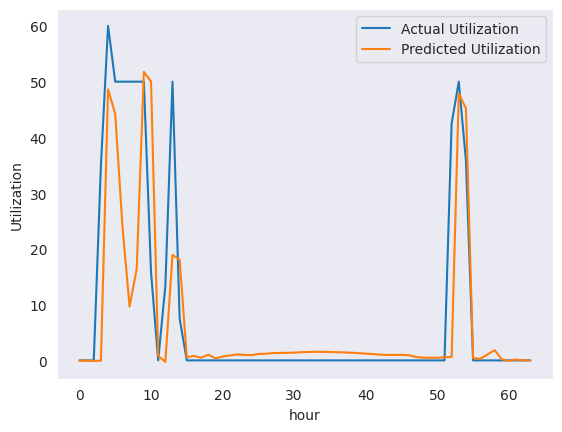

In [6]:
with torch.no_grad():
  for x_test,y_test in test_dataloader:
      #optimizer.zero_grad()

    x_test, y_test = x_test.to(device), y_test.to(device)
    x_test = torch.unsqueeze(x_test, 0).permute(1,2,0)
    # forward
    predictions = model(x_test)
    break

print(predictions.shape)

plt.plot(np.array(y_test.cpu()), label='Actual Utilization')
plt.plot(np.array(predictions.cpu()), label='Predicted Utilization')
plt.xlabel('hour')
plt.ylabel('Utilization')
plt.legend()
plt.show()